In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# arkonil0904
# project_directory = "/content/drive/MyDrive/projects/anime_recommender/"

# arkonil0905
# project_directory = "/content/drive/MyDrive/anime_recommender/"

project_directory = "."

In [ ]:
import os
import math
import warnings
import shutil
if not os.path.isdir('./data'):
    shutil.copytree(os.path.join(project_directory, 'data'), './data')

In [ ]:
try:
    import cupy as np
    import cupyx.scipy as cscipy
    from cupyx.scipy.sparse import linalg
except ModuleNotFoundError:
    import numpy as np
    import scipy as cscipy
    from scipy.sparse import linalg

import matplotlib.pyplot as plt
%matplotlib inline

# import scipy
import pandas as pd

from scipy import stats

from tqdm import tqdm, trange

from IPython.display import clear_output

# Importing Data

## Anime Data

In [ ]:
anime = pd.read_csv('./data/anime.csv')

# replacing unknown values with np.nan
anime = anime.replace('Unknown', np.nan) 

# changing dtypes
anime = anime.astype('float', errors='ignore') 
anime = anime.astype('int', errors='ignore')

# renaming and selecting required columns
anime = anime.rename(columns=lambda s: s.lower()).rename(columns={'mal_id': 'anime_id'})
anime = anime[['name', 'anime_id', 'score', 'genres', 'type', 'episodes', 'studios', 'rating', 
               'score-1', 'score-2', 'score-3', 'score-4', 'score-5', 'score-6', 'score-7', 
               'score-8', 'score-9', 'score-10']]

# filtering through animes which has no reviews
anime = anime[anime.iloc[:, -10:].notna().any(axis=1)]
# anime = anime.iloc[:, :-10]

anime = anime.set_index('anime_id')
anime

,name,score,genres,type,episodes,studios,rating,score-1,score-2,score-3,score-4,score-5,score-6,score-7,score-8,score-9,score-10
anime_id,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26.0,Sunrise,R - 17+ (violence & profanity),1580.0,741.0,1357.0,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0
5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1.0,Bones,R - 17+ (violence & profanity),379.0,109.0,221.0,577.0,1877.0,5805.0,22632.0,49505.0,49201.0,30043.0
6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26.0,Madhouse,PG-13 - Teens 13 or older,533.0,316.0,664.0,1965.0,5838.0,15376.0,49432.0,86142.0,75651.0,50229.0
7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,26.0,Sunrise,PG-13 - Teens 13 or older,131.0,164.0,353.0,1083.0,2920.0,5709.0,11618.0,10128.0,4806.0,2182.0
8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,52.0,Toei Animation,PG - Children,27.0,50.0,83.0,265.0,634.0,1068.0,1713.0,1242.0,529.0,312.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48418,Maou Gakuin no Futekigousha: Shijou Saikyou no...,NaN,"Action, Demons, Magic, Fantasy, School",TV,NaN,SILVER LINK.,R - 17+ (violence & profanity),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
48456,SK∞: Crazy Rock Jam,6.52,"Comedy, Sports",Special,1.0,Bones,PG-13 - Teens 13 or older,55.0,12.0,43.0,111.0,691.0,1465.0,1226.0,520.0,290.0,302.0
48480,Wan Jie Shen Zhu 3rd Season,NaN,"Adventure, Fantasy",ONA,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN


In [ ]:
def split(item):
    if pd.isnull(item):
        return np.nan
    return item.split(', ')

genres = (anime.genres
          .apply(split)
          .apply(pd.Series)
          .stack()
          .reset_index(drop=True)
          .drop_duplicates()
          )
print(f'Number of Genres: {len(genres)}')

studios = (anime.studios
           .apply(split)
           .apply(pd.Series)
           .stack()
           .reset_index(drop=True)
           .drop_duplicates()
           )
print(f'Number of Studios: {len(studios)}')

Number of Genres: 43
Number of Studios: 709


## Exploratory Data Analysis

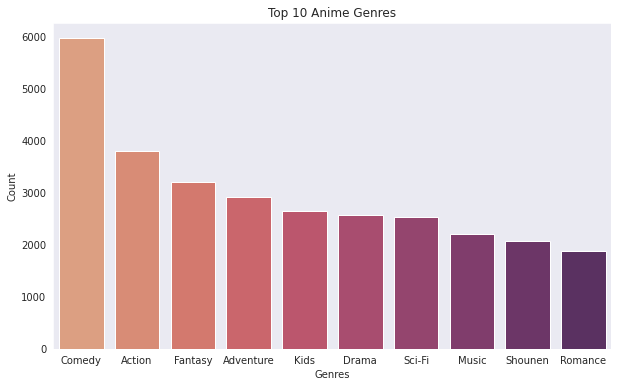

In [ ]:
# Genre Count
import seaborn as sns
sns.set_style("dark")

genre_counts = genres.apply(lambda g: anime.genres.str.contains(g).sum())
genre_counts.index = genres 
genre_counts.sort_values(ascending=False, inplace=True)
counts = genre_counts[:10]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts, palette='flare',ax=ax)
ax.set_title(f"Top {len(counts)} Anime Genres")
ax.set_xlabel("Genres")
ax.set_ylabel("Count")
plt.show()

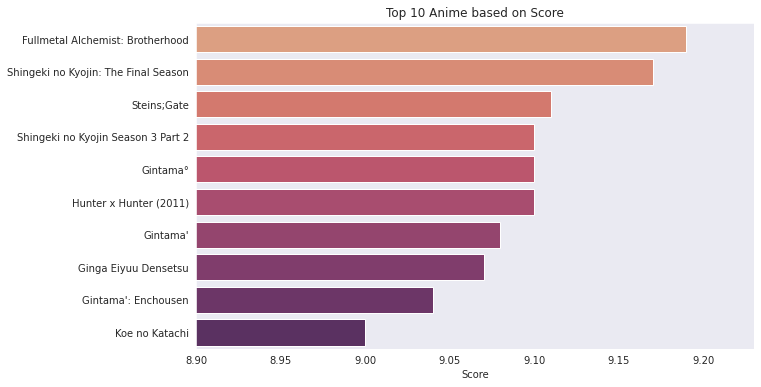

In [ ]:
scores = anime[['name', 'score']].sort_values('score', ascending=False).set_index('name')['score'][:10]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=scores.index, x=scores, palette='flare', orient='h', ax=ax)
ax.set_title(f"Top {len(scores)} Anime based on Score")
ax.set_ylabel('')
ax.set_xlabel("Score")
ax.set_xlim(min(scores)-0.1, max(scores)+0.04)
plt.show()

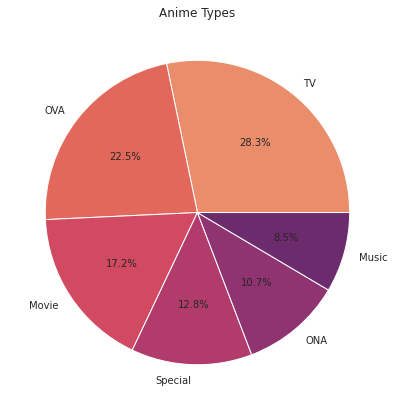

In [ ]:
counts = anime.type.value_counts()

fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(counts, labels=counts.index, autopct="%1.1f%%", colors=sns.color_palette('flare'))
ax.set_title("Anime Types")
plt.show()

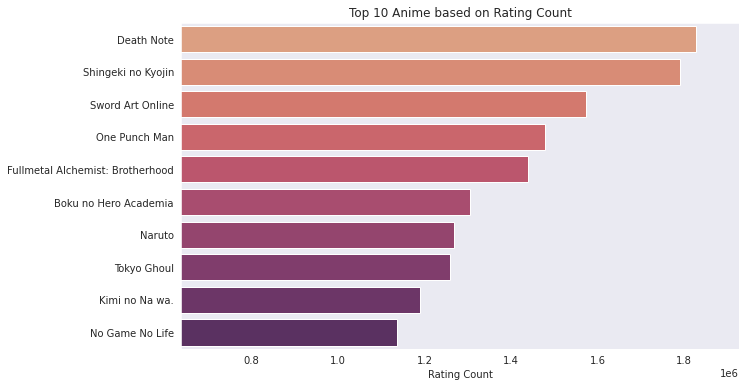

In [ ]:
rating_counts = anime.iloc[:, -10:].sum(axis=1).sort_values(ascending=False)[:10]
names = anime.loc[rating_counts.index, 'name']

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=names, x=rating_counts, palette='flare', orient='h', ax=ax)
ax.set_title(f"Top {len(names)} Anime based on Rating Count")
ax.set_ylabel('')
ax.set_xlabel("Rating Count")
ax.set_xlim(min(rating_counts)-5e5, max(rating_counts)+1e5)
plt.show()

## Rating Data

In [ ]:
animelist = pd.read_csv('./data/animelist.csv', dtype={
    'user_id': np.uint32, 
    'anime_id': np.uint16, 
    'rating': np.uint8, 
    'watching_status': np.uint8,
    'watched_episodes': np.uint16
})

animelist.set_index('anime_id', inplace=True)
missing_index = list(set(animelist.index) - set(anime.index))
animelist.drop(index=missing_index, inplace=True)

animelist = animelist[(animelist.watched_episodes > 0) 
                    & (animelist.watching_status != 6) 
                    & (animelist.rating > 0)]
animelist.drop(columns=['watching_status', 'watched_episodes'], inplace=True)

animelist.reset_index(drop=False, inplace=True)

animelist

,anime_id,user_id,rating
0,67,0,9
1,6702,0,7
2,242,0,10
3,24,0,9
4,4722,0,8
...,...,...,...
61626734,243,353404,7
61626735,507,353404,7
61626736,392,353404,9
61626737,882,353404,6


## Building Sparse matrix
for efficient computation

In [ ]:
anime_dummy, anime_ids = pd.factorize(animelist.anime_id)
user_dummy, user_ids = pd.factorize(animelist.user_id)

In [ ]:
# row indices: anime id
# column indices: user id
rating = cscipy.sparse.coo_matrix((np.array(animelist.rating.values), (np.array(anime_dummy), np.array(user_dummy))), dtype='f')
rating = rating.tocsc()

non_zero = rating.astype('bool').astype('f')

In [ ]:
# filtering users who have more than 100 ratings
num_ratings = non_zero.sum(axis=0).flatten()

# min_ratings = 0
# min_ratings = 50
min_ratings = 100
rating = rating[:, num_ratings > min_ratings]
non_zero = non_zero[:, num_ratings > min_ratings]

rating.shape

(17151, 175273)

# Training Algorithm

## Cosine Similarity

In [ ]:
def train_test_split(rating, test_size=0.25):
    n_anime, n_user = rating.shape
    train_indices = np.random.choice(n_user, size=int(n_user*(1 - test_size)), replace=False)
    mask = np.zeros(n_user, dtype='bool')
    mask[train_indices] = True

    train_data = rating[:, mask]
    test_data = rating[:, ~mask]

    return train_data, test_data

In [ ]:
train_rating, test_rating = train_test_split(rating)
train_rating.shape, test_rating.shape

((17151, 131454), (17151, 43819))

In [ ]:
warnings.filterwarnings("ignore")

class CFuCS:
    def fit(self, rating, non_zero=None):
        
        if non_zero is None:
            non_zero = rating.astype('bool').astype('f')
        # self.n_anime, _ = rating.shape
        mean_ratings = rating.sum(axis=0) / non_zero.sum(axis=0)
        rating = rating - non_zero.multiply(mean_ratings)
        self.train_data = rating
        # self.non_zero = non_zero
        self.norms = linalg.norm(self.train_data, axis=0).reshape(1, -1)

    def predict(self, user_data):
        _, n_user = user_data.shape
        batch_size = 100

        non_zero = user_data.astype('bool').astype('f')
        mean_ratings = user_data.sum(axis=0) / non_zero.sum(axis=0)
        user_data = user_data - non_zero.multiply(mean_ratings)

        user_data_pred = np.zeros(user_data.shape)
        for iter in range(math.ceil(n_user / batch_size)):
            s = slice(iter*batch_size, (iter+1)*batch_size)
            x = user_data[:, s]
            cos_sim = self.train_data.T.dot(x) / self.norms.T
            cos_sim = np.nan_to_num(cos_sim)
            cos_sim_sum = cos_sim.sum(axis=0)
            user_data_pred[:, s] = self.train_data.dot(cos_sim) / cos_sim_sum
        
        return user_data_pred
        
    def mapk_score(self, user_data, N=10):
        _, n_user = user_data.shape
        batch_size = 50
        # user_data_pred = self.predict(user_data)

        non_zero = user_data.astype('bool').astype('f')
        
        scores = np.zeros(n_user)
        for iter in trange(math.ceil(n_user / batch_size)):
            s = slice(iter*batch_size, (iter+1)*batch_size)
            user_data_pred = self.predict(user_data[:, s])

            batch_scores = np.zeros(min(batch_size, n_user - iter*batch_size))
            for i in range(len(batch_scores)):
                y_pred = user_data_pred[:, i]
                y_pred = np.argsort(y_pred)[::-1][:N].flatten()
                
                y = non_zero[y_pred, iter*batch_size + i]
                y = np.cumsum(y.A)
                y = y / np.linspace(1, N, N)

                batch_scores[i] = np.sum(y) / min(N, non_zero[:, iter*batch_size + i].sum())

            scores[s] = batch_scores

        return scores.mean()

    def spearmanr_score(self, user_data):
        _, n_user = user_data.shape
        batch_size = 50

        with warnings.catch_warnings():
            non_zero = user_data.astype('bool').astype('f')
            mean_ratings = user_data.sum(axis=0) / non_zero.sum(axis=0)
            Y = user_data - non_zero.multiply(mean_ratings)

            scores = np.zeros(n_user)
            for iter in trange(math.ceil(n_user / batch_size)):
                s = slice(iter*batch_size, (iter+1)*batch_size)
                user_data_pred = self.predict(user_data[:, s])

                batch_scores = np.zeros(min(batch_size, n_user - iter*batch_size))
                for i in range(len(batch_scores)):
                    y_pred = user_data_pred[non_zero[:, iter*batch_size + i].A.flatten().astype('bool'), i]
                    y = Y[non_zero[:, iter*batch_size + i].A.flatten().astype('bool'), iter*batch_size + i]

                    r1 = stats.rankdata(y.A.get().flatten(), method='dense')
                    r2 = stats.rankdata(y_pred.get().flatten(), method='dense')

                    batch_scores[i] = stats.spearmanr(r1, r2).correlation

            scores[s] = batch_scores

        return np.average(scores[~np.isnan(scores)], 
                          weights=non_zero.sum(axis=0).flatten()[~np.isnan(scores)])


In [ ]:
# data > 0
knn = CFuCS()
knn.fit(train_rating)
scores = knn.mapk_score(test_rating)
print(scores)

100%|██████████| 877/877 [23:02<00:00,  1.58s/it]


0.7184462873331919


In [ ]:
# data > 50
knn = CFuCS()
knn.fit(train_rating)
scores = knn.mapk_score(test_rating)
print(scores)

100%|██████████| 877/877 [23:02<00:00,  1.58s/it]


0.7452159832712869


In [ ]:
# data > 100
knn = CFuCS()
knn.fit(train_rating)
scores = knn.mapk_score(test_rating)
print(scores)

100%|██████████| 877/877 [23:02<00:00,  1.58s/it]


0.7534363952797168


# Results

| min rating |Mean Average Precision at K|
|:----------:|:-------------------------:|
|     0      |    0.7184462873331919     |
|     50     |    0.7452159832712869     |
|    100     |    0.7534363952797168     |

